<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/Training_NLP_false_positive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Clear the TensorFlow session and reset the computational graph
tf.keras.backend.clear_session()

In [2]:
# Specify the path to the CSV file
csv_file_path = '/content/true_positive_experimentation.csv'

# Load the CSV file into a DataFrame
balanced_df = pd.read_csv(csv_file_path)

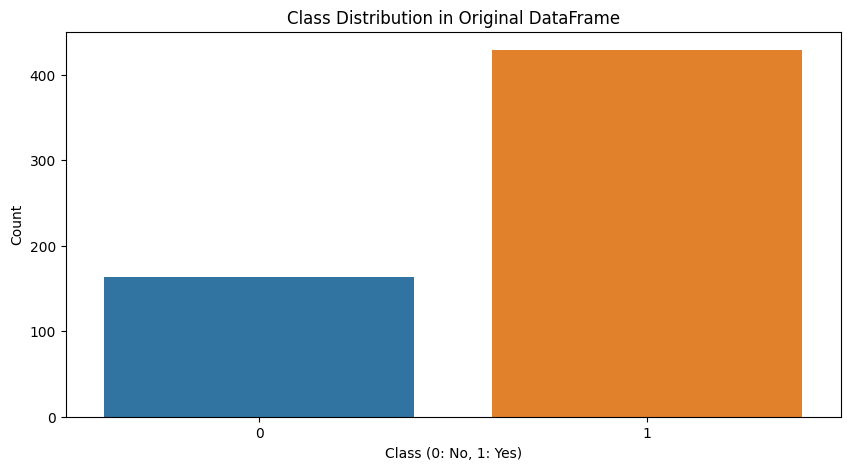

<Figure size 1000x500 with 0 Axes>

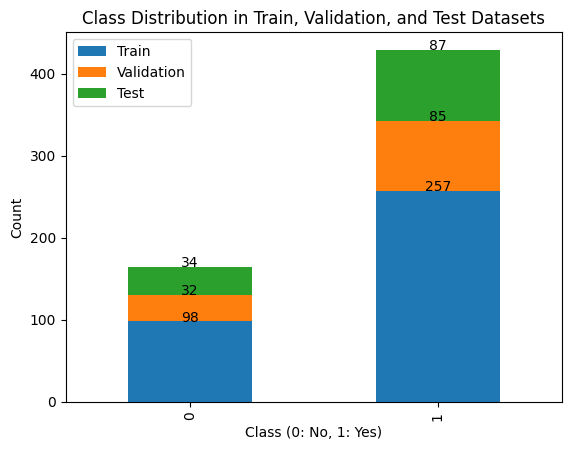

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Assuming you already have your 'balanced_df' DataFrame

# Create a bar plot to visualize the class distribution in the original DataFrame
plt.figure(figsize=(10, 5))
sns.countplot(data=balanced_df, x="label_code")
plt.title("Class Distribution in Original DataFrame")
plt.xlabel("Class (0: No, 1: Yes)")
plt.ylabel("Count")
plt.show()

# Separate the data into two DataFrames based on the label_code
df_class_0 = balanced_df[balanced_df["label_code"] == 0]
df_class_1 = balanced_df[balanced_df["label_code"] == 1]

# Shuffle the DataFrames
df_class_0 = shuffle(df_class_0, random_state=42)
df_class_1 = shuffle(df_class_1, random_state=42)

# Split each class into train, validation, and test sets
train_frac = 0.6
val_frac = 0.2

# Split class 0
train_size_class_0 = int(train_frac * len(df_class_0))
val_size_class_0 = int(val_frac * len(df_class_0))

train_class_0 = df_class_0[:train_size_class_0]
val_class_0 = df_class_0[train_size_class_0:train_size_class_0 + val_size_class_0]
test_class_0 = df_class_0[train_size_class_0 + val_size_class_0:]

# Split class 1
train_size_class_1 = int(train_frac * len(df_class_1))
val_size_class_1 = int(val_frac * len(df_class_1))

train_class_1 = df_class_1[:train_size_class_1]
val_class_1 = df_class_1[train_size_class_1:train_size_class_1 + val_size_class_1]
test_class_1 = df_class_1[train_size_class_1 + val_size_class_1:]

# Concatenate the balanced train, validation, and test sets
train_df = pd.concat([train_class_0, train_class_1])
val_df = pd.concat([val_class_0, val_class_1])
test_df = pd.concat([test_class_0, test_class_1])

# Shuffle the combined DataFrames
train_df = shuffle(train_df, random_state=42)
val_df = shuffle(val_df, random_state=42)
test_df = shuffle(test_df, random_state=42)

# Extract examples and labels from the split DataFrames
train_examples = train_df["doc_text_original"]
train_labels = train_df["label_code"]

val_examples = val_df["doc_text_original"]
val_labels = val_df["label_code"]

test_examples = test_df["doc_text_original"]
test_labels = test_df["label_code"]

# Now you have balanced train, validation, and test sets with equal distribution of classes.

# Create a DataFrame to store class distribution in train, val, and test sets
class_distribution_df = pd.DataFrame({
    "Train": train_df["label_code"].value_counts().sort_index(),
    "Validation": val_df["label_code"].value_counts().sort_index(),
    "Test": test_df["label_code"].value_counts().sort_index()
})

# Create a clustered bar plot to visualize the class distribution with labels
plt.figure(figsize=(10, 5))
ax = class_distribution_df.plot(kind="bar", stacked=True)
plt.title("Class Distribution in Train, Validation, and Test Datasets")
plt.xlabel("Class (0: No, 1: Yes)")
plt.ylabel("Count")

# Add labels to the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f"{int(height)}", (x + width/2, y + height), ha="center")

plt.show()

Transfer Model

In [4]:
"""
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=False)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()
"""

'\nmodel = "https://tfhub.dev/google/nnlm-en-dim50/2"\nhub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=False)\n\nmodel = tf.keras.Sequential()\nmodel.add(hub_layer)\nmodel.add(tf.keras.layers.Dense(16, activation=\'relu\'))\nmodel.add(tf.keras.layers.Dense(1))\n\nmodel.summary()\n'

Model Training and Selection

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the maximum sequence length and vocabulary size based on your data
max_sequence_length = 100  # Adjust as needed
vocab_size = 10000  # Adjust as needed

# Tokenize and pad your text data
tokenizer = Tokenizer(num_words=vocab_size)  # vocab_size is the size of your vocabulary
tokenizer.fit_on_texts(train_examples)

train_sequences = tokenizer.texts_to_sequences(train_examples)
val_sequences = tokenizer.texts_to_sequences(val_examples)
test_sequences = tokenizer.texts_to_sequences(test_examples)

test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
val_data = pad_sequences(val_sequences, maxlen=max_sequence_length)


In [6]:
"""
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential

# Define the maximum sequence length and vocabulary size based on your data
max_sequence_length = 100  # Adjust as needed
vocab_size = 10000  # Adjust as needed

# Create the model
model = Sequential()

# Add an Embedding layer to convert text to dense vectors
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))

# Add an LSTM layer to process the sequence data
model.add(LSTM(units=64, return_sequences=False))  # Change return_sequences to True for stacked LSTM

# Add a Dense layer for binary classification (sigmoid activation for binary classification)
model.add(Dense(units=1, activation='sigmoid'))



# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()
"""

"\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Embedding, LSTM, Dense\nfrom tensorflow.keras.models import Sequential\n\n# Define the maximum sequence length and vocabulary size based on your data\nmax_sequence_length = 100  # Adjust as needed\nvocab_size = 10000  # Adjust as needed\n\n# Create the model\nmodel = Sequential()\n\n# Add an Embedding layer to convert text to dense vectors\nmodel.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))\n\n# Add an LSTM layer to process the sequence data\nmodel.add(LSTM(units=64, return_sequences=False))  # Change return_sequences to True for stacked LSTM\n\n# Add a Dense layer for binary classification (sigmoid activation for binary classification)\nmodel.add(Dense(units=1, activation='sigmoid'))\n\n\n\n# Compile the model\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n\n# Print a summary of the model architecture\nmodel.summary()\n"

In [7]:
"""
# Bi-directional LSTM layer

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential

# Define the maximum sequence length and vocabulary size based on your data
max_sequence_length = 100  # Adjust as needed
vocab_size = 10000  # Adjust as needed

# Create the model
model = Sequential()

# Add an Embedding layer to convert text to dense vectors
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))  # Change return_sequences to True for stacked LSTM

# Add a Dense layer for binary classification (sigmoid activation for binary classification)
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()
"""

"\n# Bi-directional LSTM layer\n\nimport tensorflow as tf\nfrom tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense\nfrom tensorflow.keras.models import Sequential\n\n# Define the maximum sequence length and vocabulary size based on your data\nmax_sequence_length = 100  # Adjust as needed\nvocab_size = 10000  # Adjust as needed\n\n# Create the model\nmodel = Sequential()\n\n# Add an Embedding layer to convert text to dense vectors\nmodel.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_sequence_length))\n\n# Add a Bidirectional LSTM layer\nmodel.add(Bidirectional(LSTM(units=64, return_sequences=False)))  # Change return_sequences to True for stacked LSTM\n\n# Add a Dense layer for binary classification (sigmoid activation for binary classification)\nmodel.add(Dense(units=1, activation='sigmoid'))\n\n# Compile the model\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n\n# Print a summary of the model architecture\nm

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming you have a dataset where 'sentence' is the text data, and 'negation' is the label (1 for negated, 0 for non-negated)

# Tokenize and pad your text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(balanced_df['doc_text_original'])

sequences = tokenizer.texts_to_sequences(balanced_df['doc_text_original'])
max_sequence_length = 100  # Adjust as needed
data = pad_sequences(sequences, maxlen=max_sequence_length)

# Add binary features for negation keywords
negation_keywords = ["no", "not", "without"]  # Add more if needed
negation_features = np.zeros((len(balanced_df), len(negation_keywords)), dtype=np.int32)

for i, sentence in enumerate(balanced_df['doc_text_original']):
    for j, keyword in enumerate(negation_keywords):
        if keyword in sentence:
            negation_features[i, j] = 1

train_indices = np.arange(len(train_data))
val_indices = np.arange(len(val_data))
test_indices = np.arange(len(test_data))


train_negation_features = negation_features[train_indices]
val_negation_features = negation_features[val_indices]
test_negation_features = negation_features[test_indices]

# Define a function to create the model
def create_model():
    text_input = Input(shape=(max_sequence_length,))
    negation_input = Input(shape=(len(negation_keywords),))
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_sequence_length)(text_input)
    lstm_layer = LSTM(units=64)(embedding_layer)
    combined = Concatenate()([lstm_layer, negation_input])
    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[text_input, negation_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_model()

# Train the model
history = model.fit(
    x=[train_data, train_negation_features],
    y=train_labels,
    epochs=40,
    batch_size=512,
    validation_data=([val_data, val_negation_features], val_labels),
    verbose=1
)

# Evaluate the model on test data
results = model.evaluate([test_data, test_negation_features], test_labels)
print(results)

Epoch 1/40
1/1 [==============================] - 4s 4s/step - loss: 0.6858 - accuracy: 0.5915 - val_loss: 0.6799 - val_accuracy: 0.7350
Epoch 2/40
1/1 [==============================] - 0s 432ms/step - loss: 0.6790 - accuracy: 0.7465 - val_loss: 0.6733 - val_accuracy: 0.7265
Epoch 3/40
1/1 [==============================] - 0s 452ms/step - loss: 0.6719 - accuracy: 0.7239 - val_loss: 0.6663 - val_accuracy: 0.7265
Epoch 4/40
1/1 [==============================] - 0s 419ms/step - loss: 0.6642 - accuracy: 0.7239 - val_loss: 0.6586 - val_accuracy: 0.7265
Epoch 5/40
1/1 [==============================] - 0s 441ms/step - loss: 0.6558 - accuracy: 0.7239 - val_loss: 0.6500 - val_accuracy: 0.7265
Epoch 6/40
1/1 [==============================] - 0s 425ms/step - loss: 0.6463 - accuracy: 0.7239 - val_loss: 0.6403 - val_accuracy: 0.7265
Epoch 7/40
1/1 [==============================] - 0s 430ms/step - loss: 0.6354 - accuracy: 0.7239 - val_loss: 0.6290 - val_accuracy: 0.7265
Epoch 8/40
1/1 [=======

In [11]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [12]:
# Train your model
history = model.fit(
    x = train_data,  # Training data
    y = train_labels,  # Training labels
    epochs=40,           # Number of training epochs
    batch_size=512,      # Batch size
    validation_data=(val_data, val_labels),  # Validation data
    verbose=1            # Verbosity level (0 = silent, 1 = progress bar, 2 = one line per epoch)
)

Epoch 1/40


ValueError: ignored

In [ ]:
results = model.evaluate(test_data, test_labels)

print(results)

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming your model has already been trained and evaluated as you mentioned

# Make predictions on the test data
predicted_labels = model.predict(test_data)

# Convert the predicted probabilities to binary labels (0 or 1)
predicted_labels_binary = np.argmax(predicted_labels, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(test_labels, predicted_labels_binary)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate additional evaluation metrics
accuracy = accuracy_score(test_labels, predicted_labels_binary)
precision = precision_score(test_labels, predicted_labels_binary)
recall = recall_score(test_labels, predicted_labels_binary)
f1 = f1_score(test_labels, predicted_labels_binary)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

In [ ]:
import pandas as pd

# Assuming you have already made predictions on your test data as mentioned earlier

# Create a DataFrame with the original text, true labels, and predicted labels
results_df = pd.DataFrame({'doc_text_original': test_examples, 'label_code': test_labels, 'predicted_label': predicted_labels_binary})



In [ ]:
# Display the DataFrame
results_df